# Exploratory Data Analysis
This notebook is intended for exploratory data analysis for the RooVision project, with the intention of providing a basic understanding of the underlying data.
## Detection and Classification of Macropodidae

In [59]:
from collections import Counter, OrderedDict
import math
import os
from pathlib import Path
import re
import yaml

%matplotlib inline
from easyimages import EasyImageList
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [60]:
# set image and label directories
IMAGE_TRAIN_DIR = Path.cwd().parent / 'data' / 'images' / 'train' / 'images'
IMAGE_TEST_DIR = Path.cwd().parent / 'data' / 'images' / 'test' / 'images'
IMAGE_VALID_DIR = Path.cwd().parent / 'data' / 'images' / 'valid' / 'images'

LABEL_TRAIN_DIR = Path.cwd().parent / 'data' / 'images' / 'train' / 'labels'
LABEL_TEST_DIR = Path.cwd().parent / 'data' / 'images' / 'test' / 'labels'
LABEL_VALID_DIR = Path.cwd().parent / 'data' / 'images' / 'valid' / 'labels'

# get all images and labels
all_images = []
for DIR in [IMAGE_TRAIN_DIR, IMAGE_VALID_DIR, IMAGE_TEST_DIR]:
    p = Path(DIR).glob('**/*.jpg')
    all_images.extend(x for x in p if x.is_file())
    
all_labels = []
for DIR in [LABEL_TRAIN_DIR, LABEL_VALID_DIR, LABEL_TEST_DIR]:
    p = Path(DIR).glob('**/*.txt')
    all_labels.extend(x for x in p if x.is_file())

In [61]:
yaml_file_path = '/Users/romanwolf/Code/RooVision/data/images/data.yaml'

# open yaml file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

species = data['names']
species

['Bridled-nail-tail wallaby',
 'Brush-tailed rock-wallaby',
 'Eastern grey kangaroo',
 'Red kangaroo',
 'Red-necked wallaby',
 'Swamp wallaby',
 'Western grey kangaroo']

## Visual data inspection

In [62]:
Li = EasyImageList.from_folder(IMAGE_TRAIN_DIR)
Li.symlink_images()
Li.html()

In [63]:
Li = EasyImageList.from_folder(IMAGE_VALID_DIR)
Li.symlink_images()
Li.html()

In [64]:
Li = EasyImageList.from_folder(IMAGE_TEST_DIR)
Li.symlink_images()
Li.html()

## Image sizes and aspect ratios

In real-world scenarios, datasets often contain images of varying sizes and aspect ratios. Analysing the basic statistics of datasets, such as aspect ratios, image widths and heights, is critical to making informed decisions:

- Considering whether to perform destructive resizing, which changes aspect ratios, and whether it is necessary.
- For non-destructive resizing, determining the preferred output resolution and amount of padding is essential. This decision affects the hyperparameters of the deep learning model, such as anchor size and ratios, and may even involve meeting minimum input image size requirements.

In [65]:
from PIL import Image

aspect_ratio_list = []
width_height_list = []

for img_path in all_images:
    img = Image.open(img_path)
    
    width, height = img.size
    width_height_list.append((width, height))
    
    aspect_ratio = width/height
    aspect_ratio_list.append(aspect_ratio)

print(f' aspect ratio: {set(aspect_ratio_list)}\n',
      f'width, height: {set(width_height_list)}')

 aspect ratio: {0.66650390625, 0.750733137829912, 1.0740740740740742, 1.3333333333333333, 1.2040816326530612, 1.5003663003663004, 1.4222222222222223, 1.4524822695035462, 1.345291479820628, 1.5, 1.509453781512605, 1.604982206405694, 0.74951171875, 0.75, 1.0, 0.85595703125, 1.1466965285554311, 1.8789237668161436, 1.25, 0.689453125, 0.70556640625, 0.80029296875, 0.81201171875, 0.99169921875, 0.7919921875, 1.3368146214099217, 1.3664302600472813, 1.6858407079646018, 1.5015015015015014, 1.4814814814814814, 1.4291695743196091, 1.2427184466019416, 0.9929411764705882, 1.7746967071057191, 1.2735426008968609, 1.4944237918215613, 1.1460548405148294, 0.9866220735785953, 0.8832951945080092, 1.3514150943396226, 1.3016759776536313, 1.4331700489853043, 1.945475638051044, 1.503168567807351, 1.903345724907063, 1.261168384879725, 1.2733333333333334, 0.6402116402116402, 1.3598937583001327, 1.47, 1.288659793814433, 1.4684287812041117, 1.1827586206896552, 1.336996336996337, 1.3161953727506426, 1.249542403904

There is a variety of aspect ratios in the data. Let's inspect that in a histogram

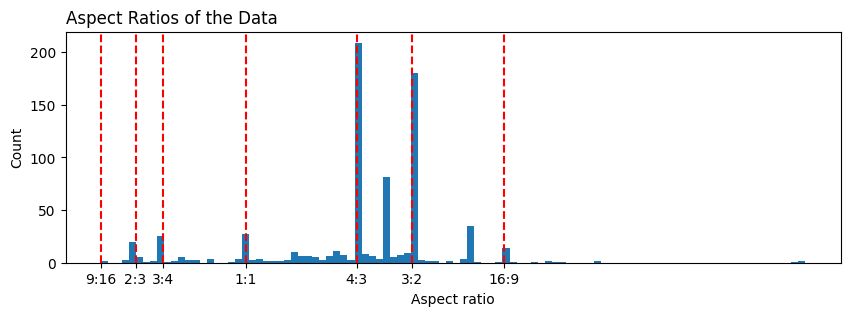

In [66]:
def plot_hist_aspect_ratios(data, title):
    """Plot a histogram of aspect ratios
    :param list data: List of aspect ratios
    :param str title: Title
    :returns: None
    """
    # Define most common aspect ratios and their labels
    most_common_aspect_ratios = [9/16, 2/3, 3/4, 1/1, 4/3, 3/2, 16/9]
    most_common_aspect_ratio_labels = ['9:16', '2:3', '3:4', '1:1', '4:3', '3:2', '16:9']

    # Create a histogram plot
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(data, bins=100)
    ax.set_xlabel('Aspect ratio')
    ax.set_ylabel('Count')
    ax.set_title(title, loc='left')

    # Add vertical lines for the most common aspect ratios
    for idx, ratio in enumerate(most_common_aspect_ratios):
        ax.axvline(x=ratio, color='red',
                   linestyle='--',
                   label=f'Aspect ratio {most_common_aspect_ratio_labels[idx]}')

    # Set x-axis ticks and labels
    ax.set_xticks(most_common_aspect_ratios)
    ax.set_xticklabels(most_common_aspect_ratio_labels)

    # Show the plot
    plt.show()


plot_hist_aspect_ratios(aspect_ratio_list, 'Aspect Ratios of the Data')

According to Wikipedia, the most common aspect ratios in still photography are 4:3, 3:2 (equivalent to 1.5:1) and, increasingly seen in consumer cameras, 16:9, which corresponds to ratios of 1.33, 1.5 or 1.77. Most of the images in the data were taken in these formats, or their inverse in the case of the upright format, but with some variations, the 3rd and 4th most common ratios are uncommon. In general, most images are wider than they are tall. This must be taken into account when pre-processing the images.

## Label (objects) sizes and dimensions

This section focuses on the analysis of target labels, specifically to understand the distribution of sizes and aspect ratios.

The importance of this analysis lies in the design constraints inherent in different modelling approaches. Models are typically optimised to perform well on standardised benchmark datasets. However, deviations from these norms in your data can make effective training of these models impossible. 

For example, if a dataset consists primarily of large objects, there may be an opportunity to significantly simplify the model. Conversely, if a dataset contains small images with small objects (e.g. 10x10px), training the model may prove challenging.

Key considerations for box or mask dimensions include
- Aspect ratio
- Size (area)

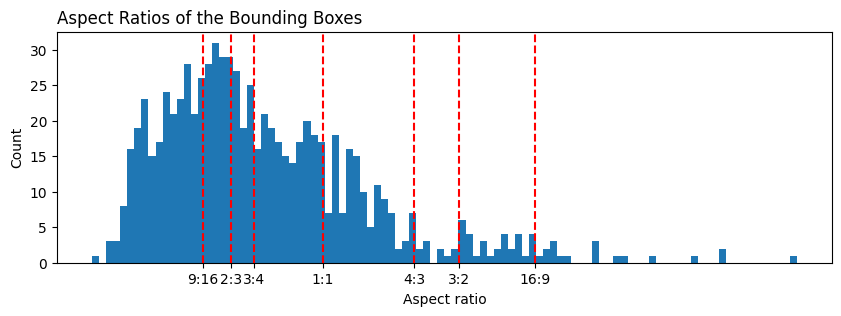

In [67]:
area_list = []
labels_list = []
aspect_ratio_list = []


for img_path in all_images:
    img = Image.open(img_path)
    
    width, height = img.size

for lbl_path, img_path in zip(all_labels, all_images):
    img = Image.open(img_path)
    image_width, image_height = img.size
    
    with open(lbl_path, 'rb') as f:
        lines = f.readlines()

        for line in lines:
            bbox = list(map(float, line.strip().split()))
            label, x_center, y_center, box_width, box_height = bbox
            
            # reformat the data from relative to absolute values in pixels
            x1 = int((x_center - box_width / 2) * image_width)
            y1 = int((y_center - box_height / 2) * image_height)
            x2 = int((x_center + box_width / 2) * image_width)
            y2 = int((y_center + box_height / 2) * image_height)
            
            area = (x2-x1) * (y2-y1) # in pix^2
            area_list.append(area)
            
            labels_list.append(label)
            aspect_ratio_list.append((box_width/box_height))
            
# plot histogram of annotation aspect ratios
plot_hist_aspect_ratios(aspect_ratio_list, 'Aspect Ratios of the Bounding Boxes')

The histogram shows that the majority of the bounding boxes have an aspect ratio of less than 1, suggesting that they are higher than they are wide. This mismatch in image format is indicative of the pose of the specimen in the images. Evaluating model training based on these ratios could provide valuable insights. It would be worth investigating whether the trained model has difficulties with certain poses, and whether examining the associated training data could improve model performance.

In [68]:
# Create a DataFrame with 'Area' and 'Species' columns
df = pd.DataFrame({'Area': area_list, 'Species': labels_list})

# Group and sort mean species area of bounding box
df = df.groupby('Species').mean()
df = df.sort_values('Area', ascending=False)

# Convert integer labels to corresponding species names
for idx, label in enumerate(df.index):
    df.loc[idx, 'Species'] = species[int(label)]

# Reset the index and return DataFrame
df = df.reset_index(drop=True)
df

,Area,Species
0,1.141035e+06,Bridled-nail-tail wallaby
1,6.103512e+05,Brush-tailed rock-wallaby
2,5.322482e+05,Eastern grey kangaroo
3,5.125599e+05,Red-necked wallaby
4,5.104396e+05,Western grey kangaroo
5,4.413769e+05,Swamp wallaby
6,4.325749e+05,Red kangaroo


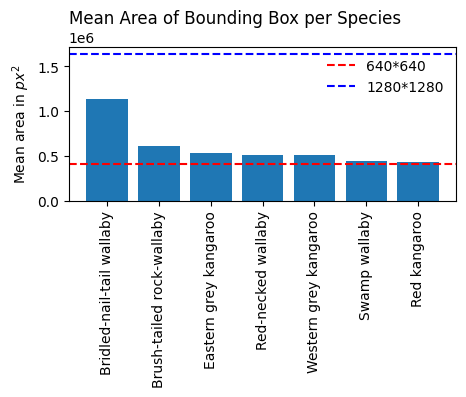

In [69]:
# create bar plot
fig, ax = plt.subplots(figsize=(5,2))
x = np.arange(len(df))

for i in range(len(df)):
    ax.bar(df.loc[i, 'Species'], df.loc[i, 'Area'], color='#1f77b4')

# Add horizontal lines at specific heights
ax.axhline(y=640*640, color='red', linestyle='--', label='640*640')
ax.axhline(y=1280*1280, color='blue', linestyle='--', label='1280*1280')

# set title, x/y-labels and x-ticks
ax.set_title('Mean Area of Bounding Box per Species', loc='left')
ax.set_ylabel('Mean area in $px^2$')
ax.set_xticks(x)
ax.set_xticklabels(df['Species'], rotation=90)

# add legend and show plot
ax.legend(frameon=False, loc='upper right')
plt.show()

The plot shows that, with the exception of the bridlednail-tail wallaby, the mean bounding box areas per species are evenly distributed. It also shows that most of the bounding boxes are relatively large compared to the image size of 640x640 pixels. The plot also suggests that there are few small annotated bridled nail-tail wallabies. This could lead to a trained model that might excel at detecting larger instances of this species, but struggle with smaller ones.

## Victorian **Macropodidae**
The next step is to investigate how many instances of species are present in the data, i.e. how many images of a species and how many instances within an image of a dominant species. This is to determine whether there is a class imbalance that could lead to biased model predictions, and to check whether there is generally enough data, as recommended by the respective model structures.

In [71]:
# get all Victorian macropod species
species = data['names']
species

['Bridled-nail-tail wallaby',
 'Brush-tailed rock-wallaby',
 'Eastern grey kangaroo',
 'Red kangaroo',
 'Red-necked wallaby',
 'Swamp wallaby',
 'Western grey kangaroo']

In [72]:
labels = []
image_labels = []

# Iterate over label txt-files
for file_path in all_labels:
    
    image_label = re.split('_\d{2}', file_path.stem)[0]
    image_label = image_label.capitalize().replace('_', ' ')
    image_labels.append(image_label)

    # open files and read lines
    with open(file_path, 'rb') as txt_file:
        lines = txt_file.readlines()
        
        # iterate
        for line in lines: 
            bbox = list(map(float, line.strip().split()))
            
            # Unpack bounding box
            label, x_center, y_center, box_width, box_height = bbox
            labels.append(species[int(label)])  # Append the species to the list

# Count the number of specimens in images according to the species name
specimen_in_images = Counter()
for specimen in labels:
    specimen_in_images[specimen] += 1

# Count the labels from the image paths, i.e. the prevailing species in the image
cnt_labels = Counter()
for label in image_labels: cnt_labels[label]+=1

# Return the dictionaries
cnt_labels, specimen_in_images = dict(cnt_labels) , dict(specimen_in_images)
cnt_labels.pop('Background')

print(cnt_labels)
print(specimen_in_images)

{'Western grey kangaroo': 100, 'Eastern grey kangaroo': 100, 'Red kangaroo': 100, 'Red-necked wallaby': 100, 'Bridled-nail-tail wallaby': 64, 'Swamp wallaby': 100, 'Brush-tailed rock-wallaby': 100}
{'Western grey kangaroo': 128, 'Eastern grey kangaroo': 133, 'Red kangaroo': 135, 'Red-necked wallaby': 111, 'Bridled-nail-tail wallaby': 75, 'Swamp wallaby': 101, 'Brush-tailed rock-wallaby': 104}


In [87]:
import pandas as pd

# Prepare plotting_data for plotting
plotting_data = {
    'specimen_in_image': [specimen_in_images[specimen] for specimen in specimen_in_images],
    'images_with_specimen': [cnt_labels.get(specimen, 0) for specimen in specimen_in_images]
}

# Create DataFrame and sort alphabetically by species
df_plotting_data = pd.DataFrame(plotting_data, index=specimen_in_images.keys()).sort_index()

# Capitalize column names and replace underscores with spaces
df_plotting_data.columns = [col.capitalize().replace('_', ' ') for col in df_plotting_data.columns]

df_plotting_data

,Specimen in image,Images with specimen
Bridled-nail-tail wallaby,75,64
Brush-tailed rock-wallaby,104,100
Eastern grey kangaroo,133,100
Red kangaroo,135,100
Red-necked wallaby,111,100
Swamp wallaby,101,100
Western grey kangaroo,128,100


## Balance of the Species Classes
Visualize Specimen and Image Count

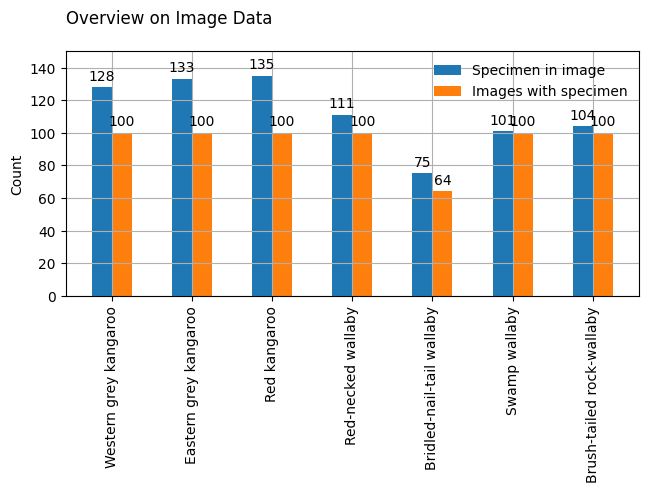

In [86]:
x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in plotting_data.items():
    offset = width * multiplier
    attribute = attribute.replace('_', ' ').capitalize()
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Overview on Image Data', loc='left', y=1.08)
ax.set_xticks(x+width/2, list_order_species, rotation=90)
ax.legend(bbox_to_anchor=(0.62, 1), frameon=False)
ax.set_ylim(0, 150)
ax.grid()

plt.show()

The figure shows that the number of instances of species per image is relatively low, i.e. slightly more than one animal per image. This should be taken into account when considering the performance of the model for images with many animals, as it is likely that the model performance could be reduced for this type of image.

## References
[How to Do Data Exploration for Image Segmentation and Object Detection (Things I Had to Learn the Hard Way)](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection) 